Student: Dorin Doncenco

In [1]:
# ! pip install datasets pandas matplotlib scikit-learn transformers rouge evaluate tqdm

In [2]:
# !wget https://gitlab.dsi.universite-paris-saclay.fr/thomas.gerald/textminingandchatbot/-/raw/main/tp/TP-1/tp-content.zip?ref_type=heads&inline=false
# !unzip tp-content.zip

# JOINT INTENT DETECTION AND SLOT FILLING

In this application we will develop different NLU systems on the ATIS, SNIPS and MEDIA datasets. The ATIS corpus a flight reservation dialogue dataset, the data are provided in the BIO format. The SNIPS corpus regroup different intent from reservation to playlist management. The MEDIA dataset is a frenc corpus on hotel booking howeve it is noisy (due to audio transcription)
Two different approaches will be considered in the current application for intent detection :
* Classifier on BOW like features
* RNN with word embedding
For slot filling the objectives is to implement an RNN (considering same model for intent detection and slot filling)


In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence


##  Part 1 : The dataset

Explore the different dataset, how they are annotated and what are their specificities

In [4]:
atis_data_path = 'data/NLU/atis-corpus/atis.{}.csv'
snips_data_path = 'data/NLU/snips-corpus/snips.{}.csv'
media_data_path = 'data/NLU/media_corpus/media.{}.csv'

#temporarily atis is no bueno maybe later it'll work if you recheck the gitlab
#current_data_path = snips_data_path
current_data_paths = [atis_data_path, snips_data_path]

In [5]:

training_sets = [pd.read_csv(current_data_paths[0].format('train'), index_col='id'), pd.read_csv(current_data_paths[1].format('train'), index_col='id')]
validation_sets = [pd.read_csv(current_data_paths[0].format('dev'), index_col='id'), pd.read_csv(current_data_paths[1].format('dev'), index_col='id')]
testing_sets = [pd.read_csv(current_data_paths[0].format('test'), index_col='id'), pd.read_csv(current_data_paths[1].format('test'), index_col='id')]

## 1.1 Plotting the data
Plot both intent and slots fot the different corpus

<Axes: xlabel='intent'>

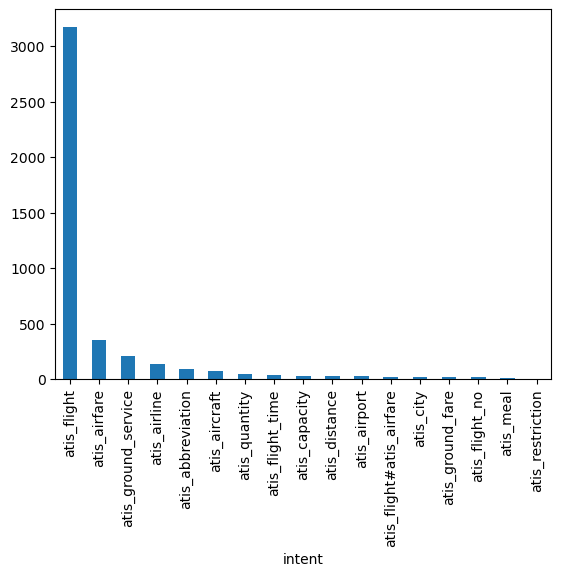

In [6]:
#snips
training_sets[0].value_counts('intent').plot.bar()

<Axes: xlabel='intent'>

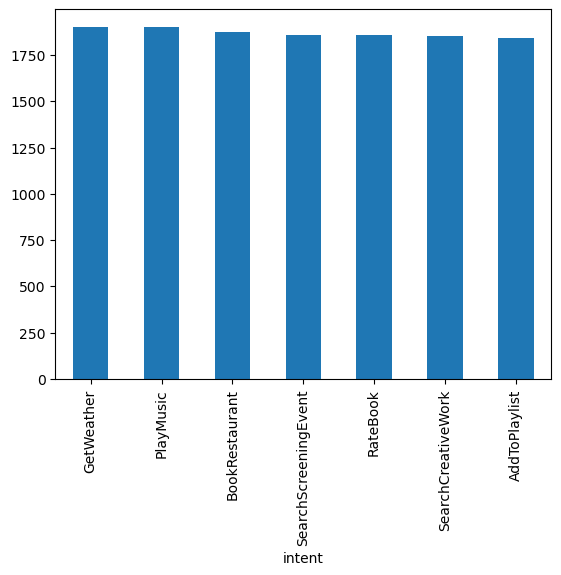

In [7]:
#snips
training_sets[1].value_counts('intent').plot.bar()

<Axes: >

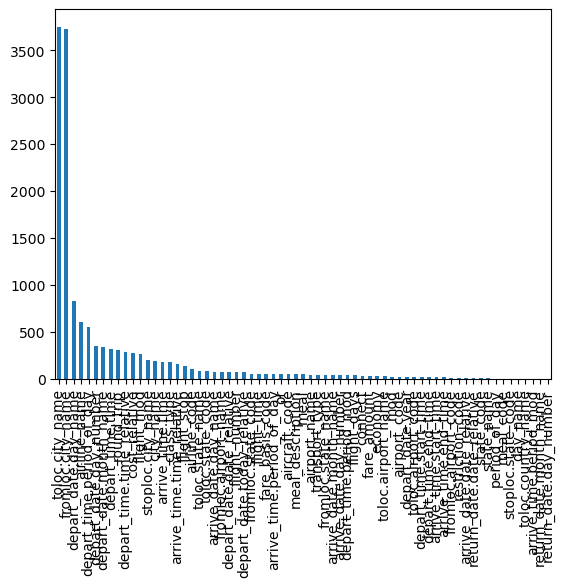

In [8]:
# regex to capture only the beginning of slots for a more accurate representation
# extract all strings between B and the next space
training_sets[0]['slots'].str.extractall(r'B-([^\s]+)').stack().value_counts().plot.bar()

<Axes: >

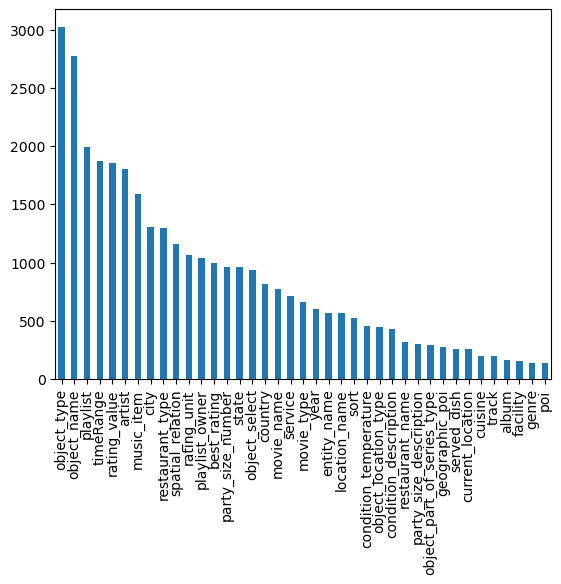

In [9]:
# regex to capture only the beginning of slots for a more accurate representation
# extract all strings between B and the next space
training_sets[1]['slots'].str.extractall(r'B-([^\s]+)').stack().value_counts().plot.bar()

In [10]:
## SNIPS dataset
# count intents
intents = training_sets[0]['intent'].unique()
print(intents)
print(len(intents))

['atis_airfare' 'atis_flight' 'atis_abbreviation' 'atis_ground_service'
 'atis_restriction' 'atis_airport' 'atis_quantity' 'atis_meal'
 'atis_airline' 'atis_city' 'atis_flight_no' 'atis_ground_fare'
 'atis_flight_time' 'atis_flight#atis_airfare' 'atis_distance'
 'atis_aircraft' 'atis_capacity']
17


In [11]:
## SNIPS dataset
# count intents
intents = training_sets[1]['intent'].unique()
print(intents)
print(len(intents))

['AddToPlaylist' 'BookRestaurant' 'GetWeather' 'PlayMusic' 'RateBook'
 'SearchCreativeWork' 'SearchScreeningEvent']
7


In [12]:
slots = training_sets[0]['slots'].str.extractall(r'B-([^\s]+)').stack().value_counts().index
print(slots)
print(len(slots))

Index(['toloc.city_name', 'fromloc.city_name', 'depart_date.day_name',
       'airline_name', 'depart_time.period_of_day', 'depart_date.day_number',
       'depart_date.month_name', 'depart_time.time', 'round_trip',
       'depart_time.time_relative', 'cost_relative', 'flight_mod',
       'stoploc.city_name', 'city_name', 'arrive_time.time', 'class_type',
       'arrive_time.time_relative', 'flight_stop', 'airline_code',
       'toloc.state_name', 'toloc.state_code', 'arrive_date.day_name',
       'fromloc.airport_name', 'depart_date.date_relative', 'flight_number',
       'depart_date.today_relative', 'fromloc.state_code', 'flight_time',
       'fare_basis_code', 'arrive_time.period_of_day', 'or', 'aircraft_code',
       'meal_description', 'meal', 'airport_name', 'transport_type',
       'fromloc.state_name', 'arrive_date.month_name',
       'arrive_date.day_number', 'depart_time.period_mod', 'flight_days',
       'connect', 'fare_amount', 'economy', 'toloc.airport_name', 'mod',
    

In [13]:
slots = training_sets[1]['slots'].str.extractall(r'B-([^\s]+)').stack().value_counts().index
print(slots)
print(len(slots))

Index(['object_type', 'object_name', 'playlist', 'timeRange', 'rating_value',
       'artist', 'music_item', 'city', 'restaurant_type', 'spatial_relation',
       'rating_unit', 'playlist_owner', 'best_rating', 'party_size_number',
       'state', 'object_select', 'country', 'movie_name', 'service',
       'movie_type', 'year', 'entity_name', 'location_name', 'sort',
       'condition_temperature', 'object_location_type',
       'condition_description', 'restaurant_name', 'party_size_description',
       'object_part_of_series_type', 'geographic_poi', 'served_dish',
       'current_location', 'cuisine', 'track', 'album', 'facility', 'genre',
       'poi'],
      dtype='object')
39


## SNIPS Dataset characteristics

* How many possible intent for each dataset?
* How many slots?
* how they are distributed ?
* What are the most frequents values ? 

##### There are 7 intents.

##### There are 39 slots.

##### Intents follow a uniform distribution. Slots are more imbalanced; with most of the slots having less than 1000 instances.

##### The most frequent slots are Object_Type, Object_Name

## ATIPS Dataset characteristics

There are 17 intents and 67 slots. The intents on the ATIPS dataset follow a long-tail distribution. The slots are also imbalanced.

The most frequent slots are toloc_cityname and fromloc_cityname.

## PART 2 Learning BOW classifiers 
From the code below propose different classifier for intent (for both snips and atis)

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 


for training_set, testing_set in zip(training_sets, testing_sets):
    text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
    ])
    
    text_clf.fit(training_set['tokens'], training_set['intent'])
    predicted = text_clf.predict(testing_set['tokens'])

    accuracy = np.mean(predicted == testing_set['intent'])
    print(accuracy) 

0.8327645051194539
0.9771428571428571


In [15]:
# do svm
from sklearn.svm import SVC
for training_set, testing_set in zip(training_sets, testing_sets):
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC()),
    ])

    text_clf.fit(training_set['tokens'], training_set['intent'])
    predicted = text_clf.predict(testing_set['tokens'])

    accuracy = np.mean(predicted == testing_set['intent'])
    print(accuracy)

0.9488054607508533
0.9814285714285714


In [16]:
# now do mlp
from sklearn.neural_network import MLPClassifier

for training_set, testing_set in zip(training_sets, testing_sets):
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MLPClassifier(hidden_layer_sizes=(64, 64))),
    ])

    text_clf.fit(training_set['tokens'], training_set['intent'])
    predicted = text_clf.predict(testing_set['tokens'])

    accuracy = np.mean(predicted == testing_set['intent'])
    print(accuracy)

0.9641638225255973
0.9857142857142858


Fill the following table replacing value and named classifiers

| Dataset   | NaiveBayes | SVM | MLP |
| -------- | ------- |------- |------- |
| ATIS  | 0.83    |0.94    | 0.95 |
| SNIPS | 0.97     |0.98    | 0.98 |



## PART 3 Learning RNN

### 1.1 Prepare the data and tools
The objective of the following question is to prepare the data to run with the model.
In this example we will create different component :
* intent_encoder (from textual intent return its id)
* slot_encoder (from list or string separated by space of textual slot return id)
* tokenizer (from list or string separated by space of textual slot return id)
* BIONLUDataset a dataset like class returning all the information necessary for training
* Dataloader that allow to create batch of the data (usefull for training)

In [17]:
'''This class encode labels or list of labels given an index
'''
class LabelEncoder:
    def __init__(self, index):
        self.index = index
        self.iindex = {v: k for k, v in index.items()}
    
    def get_id_list_from_text(self, text):
        return [self.index[w] for w in text.split()]

    def get_label_list_from_id(self, label_ids):
         return [self.iindex[lid] for lid in label_ids]

    def to_label_list(self, text):
        return text.split()

    # method call can be called by instance_object(parameters)
    def __call__(self, text):
        return self.get_id_list_from_text(text)

In [33]:
#slots = training_sets[0]['slots'].str.extractall(r'B-([^\s]+)').stack().value_counts().index
#split by space
slots = training_sets[0]['slots'].str.split().explode().value_counts().index
intents = training_sets[0]['intent'].unique()

intent_index = {intent: i for i, intent in enumerate(training_sets[0]['intent'].unique())}
slot_index = {slot: i for i, slot in enumerate(slots)}

intent_encoder = LabelEncoder(intent_index)
slot_encoder = LabelEncoder(slot_index)

In [34]:
slots

Index(['O', 'B-toloc.city_name', 'B-fromloc.city_name', 'I-toloc.city_name',
       'B-depart_date.day_name', 'I-fromloc.city_name', 'B-airline_name',
       'B-depart_time.period_of_day', 'I-airline_name',
       'B-depart_date.day_number',
       ...
       'B-stoploc.state_code', 'B-day_name', 'B-meal_code',
       'I-arrive_time.time_relative', 'I-meal_code',
       'I-return_date.date_relative', 'B-arrive_time.period_mod',
       'B-toloc.country_name', 'B-return_date.month_name',
       'B-return_date.day_number'],
      dtype='object', name='slots', length=101)

### Create a tokenizer
Fill the Tokenizer class to transform text tokens into token ids. From a list of words (or string of wards separated by space) return a sequence of ids (each word as a unique id).

In [35]:
'''This class should tokenize a text or a list of tokens.
'''  
class Tokenizer:

    def __init__(self, list_text, unk_token="UNKNOW_WORD"):
        # create a vocbulary index 
        self.vocab = np.unique([word for text in list_text for word in text.split()])
        self.vocab_index = {w: i for i, w in enumerate(self.vocab)}
        self.vocab_index[unk_token] = len(self.vocab_index)
        self.unk_token = unk_token
        
    def __call__(self, text):
        # return the ids of the text or word sequence
        return [self.vocab_index.get(w, self.vocab_index[self.unk_token]) for w in text.split()]
        
        
    def decode(self, ids):
        # from the text ids return a sentence
        return " ".join([self.vocab[i] for i in ids])
        
    def __len__(self):
        # get the vocabulary lenght
        return len(self.vocab)


In [36]:
training_set, validation_set, testing_set = training_sets[0], validation_sets[0], testing_sets[0]

tokenizer = Tokenizer(
    list(training_set['tokens']) + 
    list(validation_set['tokens']) + 
    list(testing_set['tokens'])
)


In [37]:
tokenizer.decode(tokenizer("i want to fly from boston at 838 am and arrive in denver at 1110 in the morning"))

'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'

### Create the dataset

The dataset class below must return all needed informations for prediction, here the **text** (initial utterance), the intent label name (**i_label**), the list of slots names for the sequence (**s_label**), the text transformed into list of tokens(**x**), the id of the coresponding intent (**i_id**), the list of ids of the coresponding slots names (**s_ids**) and, the len of the squence (the number of words) (**seq_len**).


In [38]:
class BIONLUDataset():
    def __init__(self, data, intent_index, slot_index, text_transform):
        self.data = data
        self.i_enc = LabelEncoder(intent_index)
        self.s_enc = LabelEncoder(slot_index)
        self.t_transform = text_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['tokens']
        i_label = row['intent']
        s_label = row['slots']
        
        x = self.t_transform(text)
        i_id = self.i_enc(i_label)[0]
        s_ids = self.s_enc(s_label)
        
        assert(len(s_ids) == len(x))
        
        return {'text': text, 'i_label': i_label, 's_labels': s_label,
                'x': x, 'i_id': i_id, 's_ids': s_ids, "seq_len": len(x)}

**Create the different set :** below we create the different, for each we give the set data, the intent_index (to allow to transform intent label to its corresponding id), the slot_index (to transform slot_type to id) and the tokenizer (which simply split text by words and return the sequence of tokens/words ids).

In [39]:
# create a simple tokenizer on all words of the corpus 

train = BIONLUDataset(training_set, intent_index, slot_index, tokenizer)
val = BIONLUDataset(validation_set, intent_index, slot_index, tokenizer)
test = BIONLUDataset(testing_set, intent_index, slot_index, tokenizer)

**The collate function:** to load the data as batch we need to return tensors to the pytorch model we will see later. Here we need as input of the model the intents ids, the slots_ids (which is a sequence of the size of text), the input given to the model (named x).

In [60]:
def rnn_collator(batch):
    i_ids = []
    seq_len = []
    s_ids = []
    x = []
    mask = []
    for item in batch:
        i_ids.append(item['i_id'])
        s_ids.append(torch.LongTensor(item['s_ids']))
        seq_len.append(item['seq_len'])
        x.append(torch.Tensor(item['x']))
        mask.append(torch.ones(item['seq_len']))

    return{
        "i_ids" : torch.LongTensor(i_ids),
        "s_ids" : pad_sequence(s_ids, padding_value=-1, batch_first=True),
        "x" : pad_sequence(x, padding_value=0, batch_first=True).long(),
        "seq_len" : torch.LongTensor(seq_len), 
        "mask": pad_sequence(mask, padding_value=0, batch_first=True)
    }

In [61]:
from torch.utils.data import DataLoader
rnn_embedding_slot_collator = rnn_collator

training_dl = DataLoader(train , batch_size=16,
                         collate_fn=rnn_embedding_slot_collator,
                         shuffle=True
                        )
validation_dl = DataLoader(val, batch_size=16,
                         collate_fn=rnn_embedding_slot_collator
                        )

### 1.2 Create the model

In [62]:
from library.model import IntentSlotRNN
class LSTMForClassification(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=300, hidden_size=100, n_slot=101, n_intent=17):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.rnn = IntentSlotRNN(embedding_size, hidden_size, n_intent, n_slot)
    
    def forward(self, input_ids, seq_len, mask=None):
        if mask is None:
            mask = input_ids.new_ones(input_ids.shape).float()
        emb = self.embedding(input_ids)
        return self.rnn(emb, seq_len, mask)
        

### 1.3 Training the model

In [63]:
from tqdm.notebook import trange, tqdm
from torch import optim
from torch import nn


class Trainer():
    def __init__(self, model):
        self.model = model 
        self.optimizer = None

    def before_training_loop(self, learning_rate = 1e-3):
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss(ignore_index=-1)

    def validation_step(self, data):
        y_pred = self.model(data["x"], data["seq_len"], data['mask'])    
        y_intent_truth = data["i_ids"]
        y_slot_truth = data["s_ids"]
        #print(y_slot_truth)
        y_intent_pred = y_pred["y_intent"]
        #print(y_pred["y_slot"].shape)
        y_slot_pred = y_pred["y_slot"].view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1)
        minus_one = (data["mask"] - 1)
        y_slot_pred *= data["mask"].view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1)
        # y_slot_pred += minus_one.view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1)
        return {
            'mask' : minus_one.view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1),
            'len' : len(data['x']),
            'intent_pred': y_intent_pred,
            'intent_truth': y_intent_truth,
            'slot_pred': y_slot_pred,
            'slot_truth': y_slot_truth
        }

    def training_step(self, data):
        y_pred = self.model(data["x"], data["seq_len"], data['mask'])    
        y_intent_truth = data["i_ids"]
        y_slot_truth = data["s_ids"]
        loss_intent = self.criterion(y_pred["y_intent"], y_intent_truth)

        y_slot_pred = y_pred["y_slot"].view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1)
        y_slot_pred *= data["mask"].view(y_slot_truth.shape[0] * y_slot_truth.shape[-1], -1)
            
        loss_slot = self.criterion(y_slot_pred, y_slot_truth.view(-1))
        (loss_slot + loss_intent).backward()
        return loss_slot.item() + loss_intent.item()

    def on_validation_end(self, resp):
        i_truth = [d["intent_truth"] for d in resp]
        s_truth = [d["slot_truth"].flatten() for d in resp]
        
        i_pred = [d["intent_pred"] for d in resp]
        s_pred =  [d["slot_pred"].argmax(-1).flatten() + d['mask'].max(-1).values.flatten() for d in resp]
        size = sum([d['len'] for d in resp ])
        print('Intent validation accuracy : %s'%(((torch.cat(i_pred).argmax(-1) == torch.cat(i_truth)).sum()/size).item(),))
        print('Slot validation accuracy : %s'%(((torch.cat(s_pred) == torch.cat(s_truth)).sum()/len(torch.cat(s_truth))).item(),))
    
    def validation(self, validation_dl):
        with torch.no_grad():
            resp = []
            for data in validation_dl:
                resp.append(self.validation_step(data))
        self.on_validation_end(resp)



    def fit(self, 
            training_dl,
            validation_dl,
            learning_rate = 1e-3,
            validation_frequency = 128,
            max_iter = 10000,
        ):

        self.before_training_loop(learning_rate)
        
        iter_count = 0
        loss_buffer = []
        pbar = trange(max_iter)
        
        while(True):
            for data in training_dl:
                self.optimizer.zero_grad()
                loss_buffer += [self.training_step(data)]
                self.optimizer.step()

                if(iter_count  % validation_frequency == 0):
                    print("Loss at iteration %s is %s"%(iter_count, np.mean(loss_buffer)))
                    self.validation(validation_dl)

                iter_count += 1
                if(iter_count >= max_iter):
                    return
                pbar.update(1)

In [64]:
MyModel = LSTMForClassification(len(tokenizer), 300, 100, len(slot_index), len(intent_index))
initial_embeddings = torch.randn(len(tokenizer), 300)
trainer = Trainer(MyModel)
trainer.fit(training_dl, validation_dl, validation_frequency=500)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss at iteration 0 is 7.4549829959869385
Intent validation accuracy : 0.5052447319030762
Slot validation accuracy : 0.4608423113822937
Loss at iteration 500 is 0.9966426952398139
Intent validation accuracy : 0.9580419659614563
Slot validation accuracy : 0.9794639945030212
Loss at iteration 1000 is 0.5749861338809895
Intent validation accuracy : 0.9790209531784058
Slot validation accuracy : 0.9877306222915649
Loss at iteration 1500 is 0.4003273882321237
Intent validation accuracy : 0.9790209531784058
Slot validation accuracy : 0.9897319674491882
Loss at iteration 2000 is 0.3059108246614079
Intent validation accuracy : 0.9807692170143127
Slot validation accuracy : 0.9913853406906128
Loss at iteration 2500 is 0.2468955792361955
Intent validation accuracy : 0.9807692170143127
Slot validation accuracy : 0.9917333722114563
Loss at iteration 3000 is 0.20686938054812118
Intent validation accuracy : 0.9807692170143127
Slot validation accuracy : 0.9916463494300842
Loss at iteration 3500 is 0.17

In [106]:
slot_index

{'O': 0,
 'B-toloc.city_name': 1,
 'B-fromloc.city_name': 2,
 'I-toloc.city_name': 3,
 'B-depart_date.day_name': 4,
 'I-fromloc.city_name': 5,
 'B-airline_name': 6,
 'B-depart_time.period_of_day': 7,
 'I-airline_name': 8,
 'B-depart_date.day_number': 9,
 'B-depart_date.month_name': 10,
 'B-depart_time.time': 11,
 'B-round_trip': 12,
 'I-round_trip': 13,
 'B-depart_time.time_relative': 14,
 'B-cost_relative': 15,
 'B-flight_mod': 16,
 'I-depart_time.time': 17,
 'B-stoploc.city_name': 18,
 'B-city_name': 19,
 'B-arrive_time.time': 20,
 'B-class_type': 21,
 'B-arrive_time.time_relative': 22,
 'I-class_type': 23,
 'I-arrive_time.time': 24,
 'B-flight_stop': 25,
 'B-airline_code': 26,
 'I-depart_date.day_number': 27,
 'I-fromloc.airport_name': 28,
 'B-toloc.state_name': 29,
 'B-toloc.state_code': 30,
 'B-arrive_date.day_name': 31,
 'B-fromloc.airport_name': 32,
 'B-depart_date.date_relative': 33,
 'B-flight_number': 34,
 'B-depart_date.today_relative': 35,
 'I-airport_name': 36,
 'I-city_na

In [104]:
data

{'i_ids': tensor([ 1,  0,  1, 14,  1,  3,  1,  3,  1, 16,  1,  1,  1,  1,  1,  1]),
 's_ids': tensor([[ 0,  0,  0,  0,  0,  2,  0,  1,  0,  4, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1],
         [ 0,  0,  0,  0,  0,  0, 21, 23,  0,  0,  2,  0,  1,  3, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1],
         [ 0, 12, 13,  0,  0,  2, 33,  4,  0,  0,  0,  1, 22, 20, 24, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1],
         [ 0,  0,  0,  0,  0, 32, 28,  0,  1,  3,  0, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1],
         [ 0,  0,  0,  0,  0,  2,  0,  1,  0, 51, 52, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1],
         [ 0,  0,  0, 19, 37, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1],
         [ 0,  0,  0,  0, 12, 13,  0,  0,  2,  5,  0,  1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1],
         [ 0,  0,  0,  0,  0,  0

### 1.4 Evaluate the model on the test set using accuracy
* Hint : see validation step

In [65]:
class NLU:
    def __init__(self, model, intent_encoder, slot_encoder, nlp):
        self.nlp = nlp
        self.model = model 
        self.intent_encoder = intent_encoder
        self.slot_encoder = slot_encoder
    
    def __call__(self, text):
        input_data = self.nlp(text)
        with torch.no_grad():
            y = self.model(torch.LongTensor([input_data]),  [len(input_data)])

        intent = self.intent_encoder.get_label_list_from_id(y['y_intent'].max(-1)[1].tolist())

        slots = self.slot_encoder.get_label_list_from_id(y['y_slot'].max(-1)[1].tolist()[0])
        return intent, list(zip(slots, text.split()))

In [67]:
nlu = NLU(MyModel, intent_encoder, slot_encoder, tokenizer)
test = BIONLUDataset(testing_set, intent_index, slot_index, tokenizer)
test_dl = DataLoader(test, batch_size=16, collate_fn=rnn_embedding_slot_collator)
print("Final test accuracy on the ATIS dataset")
trainer.validation(test_dl)


Intent validation accuracy : 0.9829351305961609
Slot validation accuracy : 0.9912202954292297


In [68]:
# train a model again on the SNIPS dataset
training_set, validation_set, testing_set = training_sets[1], validation_sets[1], testing_sets[1]

tokenizer = Tokenizer(
    list(training_set['tokens']) + 
    list(validation_set['tokens']) + 
    list(testing_set['tokens'])
)

intents = training_set['intent'].unique()
slots = training_set['slots'].str.split().explode().value_counts().index

intent_index = {intent: i for i, intent in enumerate(training_set['intent'].unique())}
slot_index = {slot: i for i, slot in enumerate(slots)}

intent_encoder = LabelEncoder(intent_index)
slot_encoder = LabelEncoder(slot_index)

train = BIONLUDataset(training_set, intent_index, slot_index, tokenizer)
val = BIONLUDataset(validation_set, intent_index, slot_index, tokenizer)
test = BIONLUDataset(testing_set, intent_index, slot_index, tokenizer)

training_dl = DataLoader(train , batch_size=16,
                            collate_fn=rnn_embedding_slot_collator,
                            shuffle=True
                            )
validation_dl = DataLoader(val, batch_size=16,
                            collate_fn=rnn_embedding_slot_collator
                            )

MyModel = LSTMForClassification(len(tokenizer), 300, 100, len(slot_index), len(intent_index))
initial_embeddings = torch.randn(len(tokenizer), 300)
trainer = Trainer(MyModel)
trainer.fit(training_dl, validation_dl, validation_frequency=500)

nlu = NLU(MyModel, intent_encoder, slot_encoder, tokenizer)
test = BIONLUDataset(testing_set, intent_index, slot_index, tokenizer)
test_dl = DataLoader(test, batch_size=16, collate_fn=rnn_embedding_slot_collator)
print("Final test accuracy on the SNIPS dataset")
trainer.validation(test_dl)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss at iteration 0 is 6.2176593542099
Intent validation accuracy : 0.2142857164144516
Slot validation accuracy : 0.45344436168670654
Loss at iteration 500 is 1.3281387704017455
Intent validation accuracy : 0.9842857122421265
Slot validation accuracy : 0.9270439147949219
Loss at iteration 1000 is 0.8580698081298376
Intent validation accuracy : 0.9885714054107666
Slot validation accuracy : 0.9524980783462524
Loss at iteration 1500 is 0.6439232739832731
Intent validation accuracy : 0.9900000095367432
Slot validation accuracy : 0.9629068970680237
Loss at iteration 2000 is 0.5153678833750885
Intent validation accuracy : 0.9857142567634583
Slot validation accuracy : 0.9656510353088379
Loss at iteration 2500 is 0.42981861571889257
Intent validation accuracy : 0.9871428608894348
Slot validation accuracy : 0.9718016386032104
Loss at iteration 3000 is 0.36548565290776924
Intent validation accuracy : 0.9857142567634583
Slot validation accuracy : 0.9704769253730774
Loss at iteration 3500 is 0.317

In [74]:
# train a model again on the ATIS dataset
training_set, validation_set, testing_set = training_sets[0], validation_sets[0], testing_sets[0]

tokenizer = Tokenizer(
    list(training_set['tokens']) + 
    list(validation_set['tokens']) + 
    list(testing_set['tokens'])
)

intents = training_set['intent'].unique()
slots = training_set['slots'].str.split().explode().value_counts().index

intent_index = {intent: i for i, intent in enumerate(training_set['intent'].unique())}
slot_index = {slot: i for i, slot in enumerate(slots)}

intent_encoder = LabelEncoder(intent_index)
slot_encoder = LabelEncoder(slot_index)

train = BIONLUDataset(training_set, intent_index, slot_index, tokenizer)
val = BIONLUDataset(validation_set, intent_index, slot_index, tokenizer)
test = BIONLUDataset(testing_set, intent_index, slot_index, tokenizer)

training_dl = DataLoader(train , batch_size=16,
                            collate_fn=rnn_embedding_slot_collator,
                            shuffle=True
                            )
validation_dl = DataLoader(val, batch_size=16,
                            collate_fn=rnn_embedding_slot_collator
                            )

MyModel = LSTMForClassification(len(tokenizer), 300, 100, len(slot_index), len(intent_index))
initial_embeddings = torch.randn(len(tokenizer), 300)
trainer = Trainer(MyModel)
trainer.fit(training_dl, validation_dl, validation_frequency=500)

nlu = NLU(MyModel, intent_encoder, slot_encoder, tokenizer)
test = BIONLUDataset(testing_set, intent_index, slot_index, tokenizer)
test_dl = DataLoader(test, batch_size=16, collate_fn=rnn_embedding_slot_collator)
print("Final accuracy on test set for ATIS dataset")
trainer.validation(test_dl)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss at iteration 0 is 7.457740306854248
Intent validation accuracy : 0.6381118893623352
Slot validation accuracy : 0.43682560324668884
Loss at iteration 500 is 0.9804836373660943
Intent validation accuracy : 0.9580419659614563
Slot validation accuracy : 0.978245735168457
Loss at iteration 1000 is 0.5617503220637373
Intent validation accuracy : 0.9790209531784058
Slot validation accuracy : 0.9863383173942566
Loss at iteration 1500 is 0.3912070773450292
Intent validation accuracy : 0.9807692170143127
Slot validation accuracy : 0.9898189902305603
Loss at iteration 2000 is 0.2986511168464472
Intent validation accuracy : 0.9807692170143127
Slot validation accuracy : 0.9910372495651245
Loss at iteration 2500 is 0.24117352811595075
Intent validation accuracy : 0.9790209531784058
Slot validation accuracy : 0.9912112951278687
Loss at iteration 3000 is 0.20206874452552684
Intent validation accuracy : 0.9790209531784058
Slot validation accuracy : 0.9918203949928284
Loss at iteration 3500 is 0.17

In [83]:
#copilot's suggestion of a naive tokenizer
naive_tokenizer = Tokenizer(
    list(training_set['tokens']) + 
    list(validation_set['tokens'])
)
nlu = NLU(trainer.model, intent_encoder, slot_encoder, naive_tokenizer)
nlu('i\'m lloking for a good restauranta in chicago')

(['atis_flight'],
 [('O', "i'm"),
  ('O', 'lloking'),
  ('B-restriction_code', 'for'),
  ('B-depart_time.time', 'a'),
  ('O', 'good'),
  ('O', 'restauranta'),
  ('O', 'in'),
  ('O', 'chicago')])

### 1.5 Change the model to use pretrained embeddings !
* You can use global pretrained embeddings for SNIPS and ATIS
* You can use pretrained last week course embeddings for MEDIA !!! 


In [98]:
import gensim
from nltk.data import find

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
embedding_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [109]:
pretrained_embeddings = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embedding_model.vectors))
word_dictionary = {word: i for i, word in enumerate(embedding_model.index_to_key)}

tokenizer = Tokenizer(
    list(training_set['tokens']) + 
    list(validation_set['tokens']) + 
    list(testing_set['tokens'])
)

# match pretrained embeddings with the tokenizer, because the indices for each word of the tokenizer are not the same as the indices of the pretrained embeddings
word2vec_embeddings = torch.zeros(len(tokenizer), 300)
for word, i in tokenizer.vocab_index.items():
    if word in word_dictionary:
        word2vec_embeddings[i] = pretrained_embeddings(torch.LongTensor([word_dictionary[word]]))

Training a model with pretrained embeddings, without freezing the embeddings:

In [126]:
# change lstm to use pre-trained embeddings
class LSTMForClassification(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=300, hidden_size=100, n_slot=101, n_intent=17, pretrained_embeddings=None):
        super().__init__()
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.rnn = IntentSlotRNN(embedding_size, hidden_size, n_intent, n_slot)
    
    def forward(self, input_ids, seq_len, mask=None):
        if mask is None:
            mask = input_ids.new_ones(input_ids.shape).float()
        emb = self.embedding(input_ids)
        return self.rnn(emb, seq_len, mask)


tokenizer = Tokenizer(
    list(training_set['tokens']) + 
    list(validation_set['tokens']) +
    list(testing_set['tokens'])
)

MyModel = LSTMForClassification(len(tokenizer), 300, 100, len(slot_index), len(intent_index), pretrained_embeddings=torch.FloatTensor(word2vec_embeddings))
trainer = Trainer(MyModel)
trainer.fit(training_dl, validation_dl, validation_frequency=500)

nlu = NLU(MyModel, intent_encoder, slot_encoder, tokenizer)
test = BIONLUDataset(testing_set, intent_index, slot_index, tokenizer)
test_dl = DataLoader(test, batch_size=16, collate_fn=rnn_embedding_slot_collator)
print("Final accuracy on test set for ATIS dataset")
trainer.validation(test_dl)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss at iteration 0 is 7.3912672996521
Intent validation accuracy : 0.7395104765892029
Slot validation accuracy : 0.5764009952545166
Loss at iteration 500 is 1.0184481073563134
Intent validation accuracy : 0.9650349617004395
Slot validation accuracy : 0.9797250032424927
Loss at iteration 1000 is 0.5770276550961366
Intent validation accuracy : 0.9685314893722534
Slot validation accuracy : 0.9906891584396362
Loss at iteration 1500 is 0.40450533830856167
Intent validation accuracy : 0.9755244851112366
Slot validation accuracy : 0.9916463494300842
Loss at iteration 2000 is 0.31107639431507955
Intent validation accuracy : 0.9737762212753296
Slot validation accuracy : 0.9918203949928284
Loss at iteration 2500 is 0.2526948781759646
Intent validation accuracy : 0.9755244851112366
Slot validation accuracy : 0.9929516315460205
Loss at iteration 3000 is 0.21275655561520868
Intent validation accuracy : 0.9755244851112366
Slot validation accuracy : 0.992342472076416
Loss at iteration 3500 is 0.1835

Training an LSTM with pretrained embeddings, while freezing the embeddings:

In [127]:
# change lstm to use pre-trained embeddings
class LSTMForClassification(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=300, hidden_size=100, n_slot=101, n_intent=17, pretrained_embeddings=None):
        super().__init__()
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.rnn = IntentSlotRNN(embedding_size, hidden_size, n_intent, n_slot)
    
    def forward(self, input_ids, seq_len, mask=None):
        if mask is None:
            mask = input_ids.new_ones(input_ids.shape).float()
        emb = self.embedding(input_ids)
        return self.rnn(emb, seq_len, mask)


tokenizer = Tokenizer(
    list(training_set['tokens']) + 
    list(validation_set['tokens']) +
    list(testing_set['tokens'])
)

MyModel = LSTMForClassification(len(tokenizer), 300, 100, len(slot_index), len(intent_index), pretrained_embeddings=torch.FloatTensor(word2vec_embeddings))
trainer = Trainer(MyModel)
trainer.fit(training_dl, validation_dl, validation_frequency=500)

nlu = NLU(MyModel, intent_encoder, slot_encoder, tokenizer)
test = BIONLUDataset(testing_set, intent_index, slot_index, tokenizer)
test_dl = DataLoader(test, batch_size=16, collate_fn=rnn_embedding_slot_collator)
print("Final accuracy on test set for ATIS dataset")
trainer.validation(test_dl)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss at iteration 0 is 7.474149942398071
Intent validation accuracy : 0.03496503457427025
Slot validation accuracy : 0.4465715289115906
Loss at iteration 500 is 0.93246115503104
Intent validation accuracy : 0.9720279574394226
Slot validation accuracy : 0.9831187129020691
Loss at iteration 1000 is 0.5213867969078047
Intent validation accuracy : 0.9737762212753296
Slot validation accuracy : 0.9895579814910889
Loss at iteration 1500 is 0.3611535152811607
Intent validation accuracy : 0.9772727489471436
Slot validation accuracy : 0.9915593266487122
Loss at iteration 2000 is 0.2768137024411545
Intent validation accuracy : 0.9790209531784058
Slot validation accuracy : 0.9927775859832764
Loss at iteration 2500 is 0.22413792423112402
Intent validation accuracy : 0.9790209531784058
Slot validation accuracy : 0.9926905632019043
Loss at iteration 3000 is 0.18829961514465768
Intent validation accuracy : 0.9790209531784058
Slot validation accuracy : 0.9928646087646484
Loss at iteration 3500 is 0.162

Comparing that to an LSTM with non-pretrained embeddings:

In [125]:
tokenizer = Tokenizer(
    list(training_set['tokens']) + 
    list(validation_set['tokens']) +
    list(testing_set['tokens'])
)

MyModel = LSTMForClassification(len(tokenizer), 300, 100, len(slot_index), len(intent_index), pretrained_embeddings=None)
trainer = Trainer(MyModel)
trainer.fit(training_dl, validation_dl, validation_frequency=500)

nlu = NLU(MyModel, intent_encoder, slot_encoder, tokenizer)
test = BIONLUDataset(testing_set, intent_index, slot_index, tokenizer)
test_dl = DataLoader(test, batch_size=16, collate_fn=rnn_embedding_slot_collator)
print("Final accuracy on test set for ATIS dataset")
trainer.validation(test_dl)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss at iteration 0 is 7.4777185916900635
Intent validation accuracy : 0.2884615361690521
Slot validation accuracy : 0.49886876344680786
Loss at iteration 500 is 0.9865422587276635
Intent validation accuracy : 0.9615384340286255
Slot validation accuracy : 0.9778106212615967
Loss at iteration 1000 is 0.5614937441299095
Intent validation accuracy : 0.9772727489471436
Slot validation accuracy : 0.9879916310310364
Loss at iteration 1500 is 0.38915142694328475
Intent validation accuracy : 0.9825174808502197
Slot validation accuracy : 0.9900800585746765
Loss at iteration 2000 is 0.29695478659752383
Intent validation accuracy : 0.9825174808502197
Slot validation accuracy : 0.9913853406906128
Loss at iteration 2500 is 0.23972270300435733
Intent validation accuracy : 0.9842657446861267
Slot validation accuracy : 0.9911242723464966
Loss at iteration 3000 is 0.20082366228353102
Intent validation accuracy : 0.9842657446861267
Slot validation accuracy : 0.9913853406906128
Loss at iteration 3500 is 

Final conclusion: The model using frozen pretrained embeddings, and the one learning the embeddings on its own, perform quite well. On the other hand, using pretrained embeddings and finetuning them leads to a slight decrease in performance.

In this lab, I have briefly analysed how the SNIPS and ATIS datasets look, and I have gotten familiar with the task of intent and slot classification. While classic methods (SVM, multi-layer perceptron, bayesian networks) perform quite well, the LSTM performs better on these tasks. I have not noticed a difference in performance when using pretrained embeddings compared to learning the embeddings on its own.